<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Helper-functions" data-toc-modified-id="Helper-functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Helper functions</a></span></li><li><span><a href="#Main-function" data-toc-modified-id="Main-function-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Main function</a></span></li><li><span><a href="#CollegeMsg-1-Week-Undir" data-toc-modified-id="CollegeMsg-1-Week-Undir-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>CollegeMsg 1 Week Undir</a></span></li><li><span><a href="#CollegeMsg-Equal-Dir" data-toc-modified-id="CollegeMsg-Equal-Dir-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>CollegeMsg Equal Dir</a></span><ul class="toc-item"><li><span><a href="#LB-=-2" data-toc-modified-id="LB-=-2-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>LB = 2</a></span></li><li><span><a href="#LB-=-4" data-toc-modified-id="LB-=-4-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>LB = 4</a></span></li></ul></li></ul></div>

In [64]:
# imports
import random

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import pickle

## Helper functions
edge_features(): generate edge features based on the two nodes' embeddings and the combine operator

generate_edge_features(): generate edge features for a list of edges

generate_train_set(): generate train set: {edges | edges' features matrix | edges labels}

generate_test_set(): generate test set: {edges | edges' features matrix | edges labels}

build_clf(): build a Logistic Regression classifier

pred_links(): predict links using LR classifier

precision_recall(): compute precision/recall of predictions

In [65]:
def edge_features(node_emb_1, node_emb_2, operator):
    
    # combine two nodes' embeddings with specificed operator
    if operator == 'Average':
        edge = [((x + y) / 2.0) for x,y in zip(node_emb_1, node_emb_2)]
    elif operator == 'Hadamard':
        edge = [(x * y) for x,y in zip(node_emb_1, node_emb_2)]
    elif operator == 'Weighted-L1':
        edge = [abs(x - y) for x,y in zip(node_emb_1, node_emb_2)]
    elif operator == 'Weighted-L2':
        edge = [abs(x - y)**2 for x,y in zip(node_emb_1, node_emb_2)]
    else:
        print("Generate edge features: Operator not supported")
        print("Use default operator: Weighted-L1")
        edge = [abs(x - y) for x,y in zip(node_emb_1, node_emb_2)]
        
    return edge

In [66]:
def generate_edge_features(edge_list, node_embeddings, operator):
    edge_features_mtx = []
    
    # generate features for each edge in the list
    for node_index_1, node_index_2 in edge_list:
        node_emb_1 = node_embeddings[node_index_1]
        node_emb_2 = node_embeddings[node_index_2]
        
        edge_features_mtx.append(edge_features(node_emb_1, node_emb_2, operator))
        
    return edge_features_mtx

In [67]:
def generate_train_set(graph_train, num_edge_sample, node_embeddings, edge_operator,):
    edge_list = list(graph_train.edges)
    num_nodes = graph_train.number_of_nodes()
    
    train_edges = []
    train_edges_labels = [1] * num_edge_sample + [0] * num_edge_sample
    
    random.seed(0)
    
    # sample edges with label 1 (true edges)
    for edge_num in range(num_edge_sample):
        rand_index = random.randint(0, len(edge_list) - 1)
        
        #train_edges.append(tuple(edge_list[rand_index]))
        train_edges.append(edge_list[rand_index])
    non_edge_num = 0
    
    # sample edges with label 0 (non-exist edges)
    while(non_edge_num < num_edge_sample):
        rand_nodes = tuple(np.random.randint(low=0,high=num_nodes, size=2))
        
        if rand_nodes not in edge_list:
            train_edges.append(rand_nodes)
            non_edge_num += 1

    train_edges_features_mtx = generate_edge_features(train_edges, node_embeddings, edge_operator)
            
    return train_edges, train_edges_features_mtx, train_edges_labels

In [94]:
def generate_test_set(graph_test, node_embeddings, edge_operator):
    edge_list = graph_test.edges
    nodes_with_edge = set()
    
    for edge in edge_list:
        nodes_with_edge.add(edge[0])
        nodes_with_edge.add(edge[1])
    
    num_nodes = graph_test.number_of_nodes()
    
    test_edges = []
    test_edges_labels = []
    
    # generate all possible edges for each node with at least one edge (assume undirected edges)
    for node_1 in nodes_with_edge:
        for node_2 in range(num_nodes):
            test_edges.append((node_1, node_2))
            
            if (node_1, node_2) in edge_list:
                test_edges_labels.append(1)
            else:
                test_edges_labels.append(0)
            
    test_edges_features_mtx = generate_edge_features(test_edges, node_embeddings, edge_operator)
    
    return test_edges, test_edges_features_mtx, test_edges_labels

In [69]:
def build_clf(feature_mtx, response_vec):
    scaler = StandardScaler()
    feature_mtx_standardized = scaler.fit_transform(feature_mtx)
    
    logistic_regression_model = LogisticRegression(random_state = 0)
    binary_clf = logistic_regression_model.fit(feature_mtx_standardized, response_vec)
    
    return binary_clf

In [70]:
def pred_links(feature_mtx, LR_clf):
    predict_edges_labels = LR_clf.predict(feature_mtx)
    
    return predict_edges_labels

In [71]:
def precision_recall(predict_labels, true_labels):
    true_positive  =false_positive = 0
    true_negative =  false_negative = 0
    
    for p_label, true_label in zip(predict_labels, true_labels):
        
        #print(p_label,true_label)
        if p_label == true_label and true_label == 1:
            true_positive += 1
        elif p_label == true_label and true_label == 0:
            true_negative += 1
        elif p_label != true_label and true_label == 1:
            false_negative += 1
        elif p_label != true_label and true_label == 0:
            false_positive += 1

    print("TP: ", true_positive)
    print("TN: ", true_negative)
    print("FP: ", false_positive)
    print("FN: ", false_negative)
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
        
    return precision, recall

## Main function
1. Load/set inputs
2. Generate train set
3. Generate test set
4. Build Logistic Regression Model
5. Predict links with model
6. Report Precision/Recall

In [ ]:
# load/set inputs

# node_embeddings
# num_edge_sample: how many edges to be samples in training set
#                  Total training samples is 2 * num_edge_sample (half edge, half non-edge)
# edge_operator = 'Average' or 'Hadamard' or 'Weighted-L1' or 'Weighted-L2'
# graph_train: the graph to be used to generate edges and edge-labels in training set
# graph_test: the graph to be used to generate edges and edge-labels in test set

In [11]:
node_embeddings = np.load('../DynamicGEM/dynamicgem/embedding/results_link_all/CollegeMsg_1_month_undir/dynAERNN/CollegeMsg_1_month_undir_gottten_embs_.npy')

In [96]:
num_edge_sample = 200
edge_operator = 'Weighted-L2'

In [97]:
with open('/z/pujat/576/data/CollegeMsg/msg_1_month_undir.pkl', 'rb') as file:
    graphs = pickle.load(file)
graph_train = graphs[-2]
graph_test = graphs[-1]

In [98]:
# generate train set
train_edges, train_edges_features_mtx, train_edges_labels = generate_train_set(graph_train, num_edge_sample, node_embeddings, edge_operator)

list(graph_train.edges)

In [99]:
# generate test set
test_edges, test_edges_features_mtx, test_edges_labels = generate_test_set(graph_test, node_embeddings, edge_operator)

In [100]:
# build LR model
LR_clf = build_clf(train_edges_features_mtx, train_edges_labels)

/z/pujat/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [101]:
# predict links
predict_edges_labels = pred_links(test_edges_features_mtx, LR_clf)

In [95]:
# report precision/recall
precision, recall = precision_recall(list(predict_edges_labels), list(test_edges_labels))
print('Precision: ', precision)
print('Recall: ', recall)

TP:  924
TN:  22759
FP:  669376
FN:  76
Precision:  0.0013784872445173804
Recall:  0.924


In [102]:
precision, recall = precision_recall(list(predict_edges_labels), list(test_edges_labels))
print('Precision: ', precision)
print('Recall: ', recall)

TP:  1000
TN:  119
FP:  692016
FN:  0
Precision:  0.001442968127719995
Recall:  1.0


In [104]:
graph_test.number_of_edges()

295

## CollegeMsg 1 Week Undir

In [13]:
with open('/z/pujat/576/data/CollegeMsg/msg_1_week_undir.pkl', 'rb') as file:
    graphs = pickle.load(file)
graph_train = graphs[-2]
graph_test = graphs[-1]

In [51]:
next_arr = np.load('/z/pujat/576/DynamicGEM/dynamicgem/embedding/results_link_all/CollegeMsg_1_week_undir/dynAERNN/msg_1_week_undir_next_pred.npy')

/z/pujat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


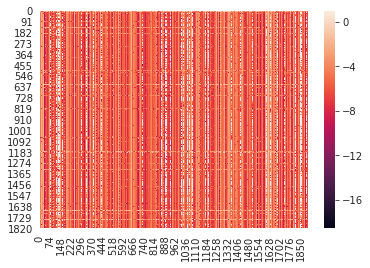

In [52]:
sns.heatmap(np.log(next_arr))

In [19]:
edge_list = list(graph_test.edges())

In [47]:
edge_list

[(8, 1899),
 (61, 1899),
 (105, 561),
 (144, 1899),
 (172, 1724),
 (193, 393),
 (204, 1899),
 (277, 1899),
 (306, 1899),
 (311, 1899),
 (314, 1899),
 (342, 969),
 (391, 1899),
 (431, 561),
 (447, 1899),
 (536, 927),
 (561, 1543),
 (561, 1899),
 (620, 818),
 (642, 711),
 (657, 1899),
 (711, 1898),
 (713, 1899),
 (784, 1899),
 (969, 1416),
 (987, 1899),
 (1097, 1899),
 (1118, 1543),
 (1215, 1899),
 (1217, 1899),
 (1280, 1783),
 (1284, 1899),
 (1312, 1344),
 (1372, 1899),
 (1417, 1899),
 (1436, 1899),
 (1497, 1899),
 (1548, 1868),
 (1624, 1878),
 (1781, 1899),
 (1792, 1899),
 (1808, 1876),
 (1847, 1899)]

In [58]:
#get the top k values for each
k = 20
counter = 0
for i,j in edge_list:
    top_k = next_arr[i].argsort()[-1 * k:][::-1]
    if j in top_k:
        counter += 1
print(counter)

2


In [54]:
top_k = next_arr[0].argsort()[-1 * 10:][::-1]

In [33]:
correct = 0
if 105 in top_k:
    correct += 1
print(correct)

1


## CollegeMsg Equal Dir 

### LB = 2

In [77]:
results_prefix = '/z/pujat/576/DynamicGEM/dynamicgem/embedding/results_link_all/CollegeMsg_equal_dir/dynAERNN/'

In [75]:
file_suffix = 'CollegeMsg_equal_dir_lb_2_l28_emb128_samples2000_next_pred.npy'

In [73]:
with open('/z/pujat/576/data/CollegeMsg/Graphs_Equal_Edge_MSG/msg_equal_edge_dir.pkl', 'rb') as file:
    graphs = pickle.load(file)
graph_train = graphs[-2]
graph_test = graphs[-1]

In [78]:
next_arr = np.load(results_prefix + file_suffix)

/z/pujat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


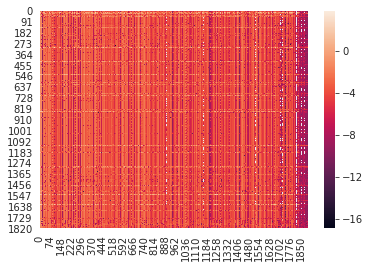

In [80]:
sns.heatmap(np.log(next_arr))

In [81]:
edge_list = list(graph_test.edges())

In [90]:
#get the top k values for each
for k in [10,20,30,40,50]:
    counter = 0
    for i,j in edge_list:
        top_k = next_arr[i].argsort()[-1 * k:][::-1]
        if j in top_k:
            counter += 1
    accuracy = counter / len(edge_list)
    print("PRECISION @ k={}, {}: ".format(k,accuracy))

PRECISION @ k=10, 0.06972477064220184: 
PRECISION @ k=20, 0.12935779816513762: 
PRECISION @ k=30, 0.16605504587155964: 
PRECISION @ k=40, 0.17889908256880735: 
PRECISION @ k=50, 0.20642201834862386: 


### LB = 4

In [91]:
file_suffix = 'CollegeMsg_equal_dir_lb_4_l28_emb128_samples2000_next_pred.npy'

/z/pujat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


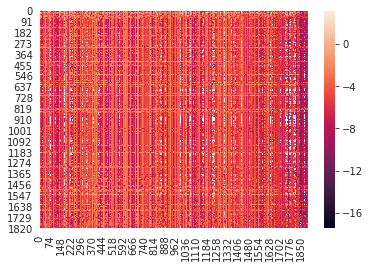

In [92]:
next_arr = np.load(results_prefix + file_suffix)
sns.heatmap(np.log(next_arr))

In [93]:
for k in [10,20,30,40,50]:
    counter = 0
    for i,j in edge_list:
        top_k = next_arr[i].argsort()[-1 * k:][::-1]
        if j in top_k:
            counter += 1
    accuracy = counter / len(edge_list)
    print("PRECISION @ k={}, {}: ".format(k,accuracy))

PRECISION @ k=10, 0.07247706422018349: 
PRECISION @ k=20, 0.10366972477064221: 
PRECISION @ k=30, 0.13853211009174313: 
PRECISION @ k=40, 0.16788990825688074: 
PRECISION @ k=50, 0.18807339449541285: 
